# Лабораторная работа 1

Цены на автомобили с учетом их особенностей

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### Подготовка данных

In [130]:
pd.set_option('display.max_columns', None)
dfInit = pd.read_csv('./data.csv', delimiter=',', encoding='utf8')
del dfInit["Id"]
df = dfInit.copy(deep=True)
df

,Make,Model,Year,Mileage,Condition,Price
0,Ford,Silverado,2022,18107,Excellent,19094.75
1,Toyota,Silverado,2014,13578,Excellent,27321.10
2,Chevrolet,Civic,2016,46054,Good,23697.30
3,Ford,Civic,2022,34981,Excellent,18251.05
4,Chevrolet,Civic,2019,63565,Excellent,19821.85
...,...,...,...,...,...,...
995,Nissan,Camry,2010,149032,Excellent,24548.50
996,Chevrolet,F-150,2014,20608,Excellent,26969.70
997,Ford,Altima,2016,109851,Good,20507.55
998,Toyota,Silverado,2010,11704,Good,31414.90


#### Преобразование параметров

In [131]:
# марка
makeList = list(set(df["Make"].map(lambda elem: elem)))

cnt = 0
makeDict = {}
for make in makeList:
    if make not in makeDict.keys():
        makeDict[make] = cnt
        cnt += 1

makeDict

{'Toyota': 0, 'Nissan': 1, 'Ford': 2, 'Chevrolet': 3, 'Honda': 4}

In [132]:
df['Make'] = df['Make'].map(lambda elem: makeDict[elem])

In [133]:
# модель
modelList = list(set(df["Model"].map(lambda elem: elem)))

cnt = 0
modelDict = {}
for model in modelList:
    if model not in modelDict.keys():
        modelDict[model] = cnt
        cnt += 1

modelDict

{'Camry': 0, 'Silverado': 1, 'Altima': 2, 'F-150': 3, 'Civic': 4}

In [134]:
df['Model'] = df['Model'].map(lambda elem: modelDict[elem])

In [135]:
# состояние
conditionDict = {'Fair': 0, 'Excellent': 1, 'Good': 2}
df['Condition'] = df['Condition'].map(lambda elem: conditionDict[elem])

In [136]:
df

,Make,Model,Year,Mileage,Condition,Price
0,2,1,2022,18107,1,19094.75
1,0,1,2014,13578,1,27321.10
2,3,4,2016,46054,2,23697.30
3,2,4,2022,34981,1,18251.05
4,3,4,2019,63565,1,19821.85
...,...,...,...,...,...,...
995,1,0,2010,149032,1,24548.50
996,3,3,2014,20608,1,26969.70
997,2,2,2016,109851,2,20507.55
998,0,1,2010,11704,2,31414.90


In [137]:
dfCopy = df.copy(deep=True)
# Мин-макс нормализация
df = (df - df.min()) / (df.max() - df.min())
# Стандартизация по z-оценке
# df = pd.DataFrame(data=StandardScaler().fit_transform(df), columns=df.columns)
df

,Make,Model,Year,Mileage,Condition,Price
0,0.50,0.25,1.000000,0.057460,0.5,0.344739
1,0.00,0.25,0.333333,0.025044,0.5,0.782267
2,0.75,1.00,0.500000,0.257488,1.0,0.589531
3,0.50,1.00,1.000000,0.178234,0.5,0.299866
4,0.75,1.00,0.750000,0.382822,0.5,0.383411
...,...,...,...,...,...,...
995,0.25,0.00,0.000000,0.994546,0.5,0.634803
996,0.75,0.75,0.333333,0.075361,0.5,0.763577
997,0.50,0.50,0.500000,0.714111,1.0,0.419880
998,0.00,0.25,0.000000,0.011631,1.0,1.000000


In [138]:
ax = df.boxplot(column=list(df.columns), figsize=(16,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax

<Axes: >

### Кластеризация, снижение размерности пространства признаков

#### Общая визуализация данных

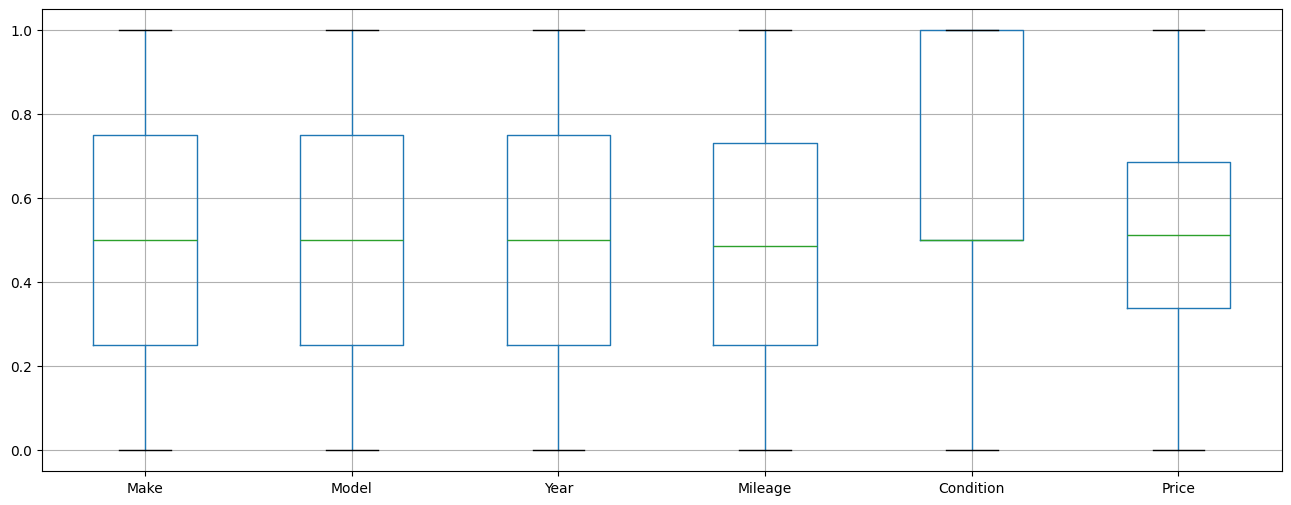

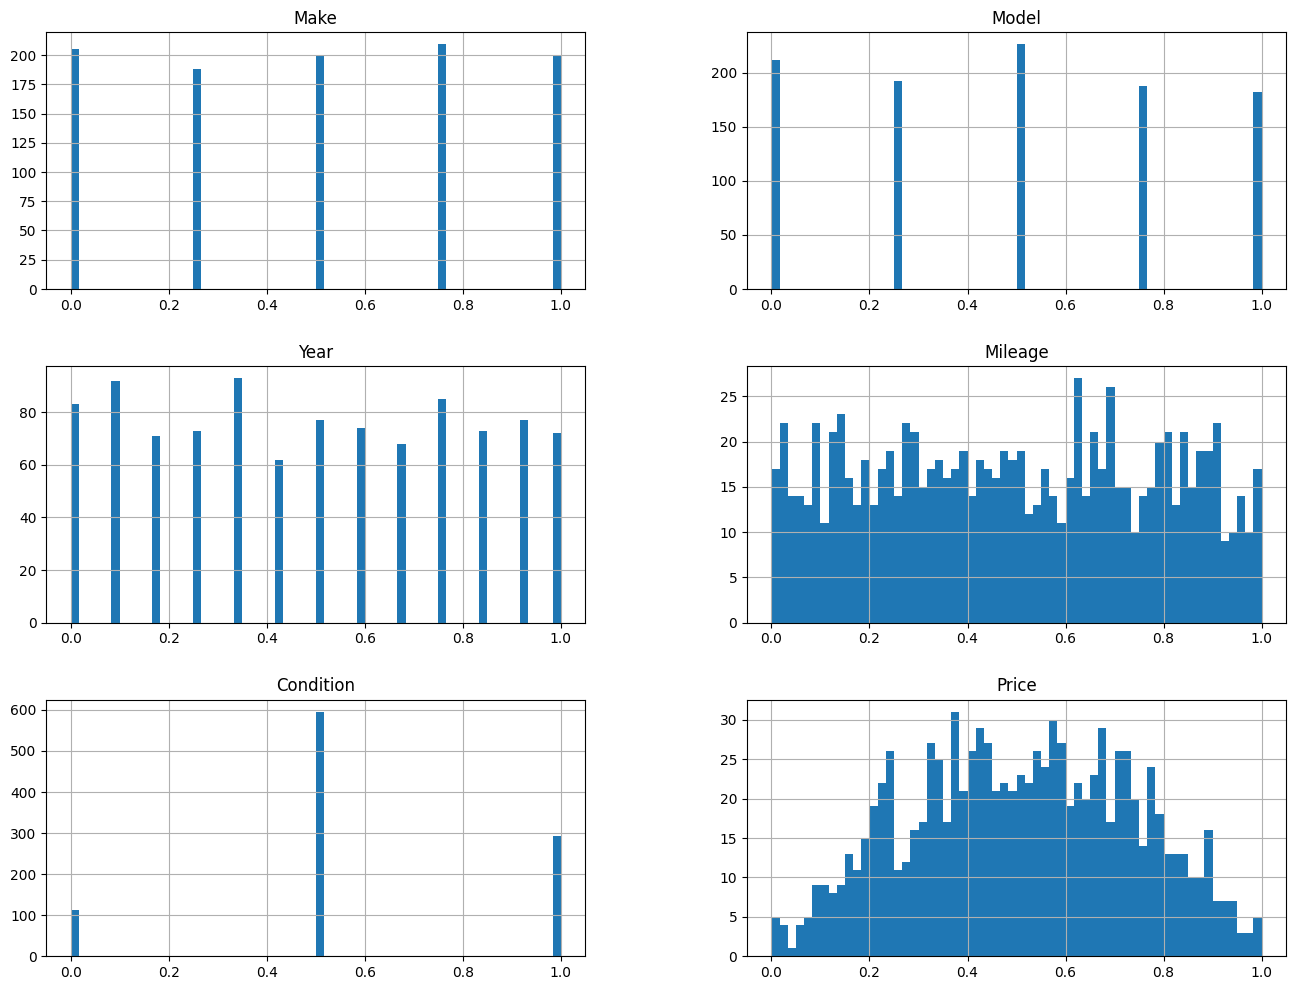

In [139]:
df.hist(bins=60, figsize=(16,12), grid=True)
plt.show()

#### Тепловая карта корреляции признаков

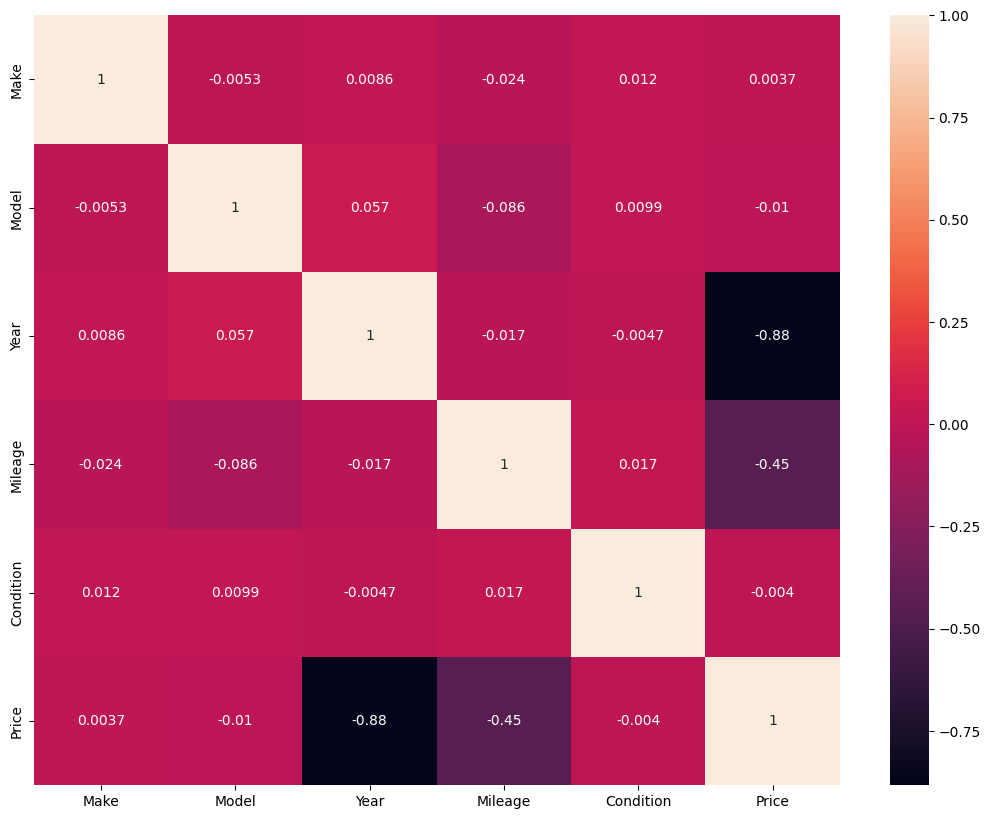

In [140]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### k-means

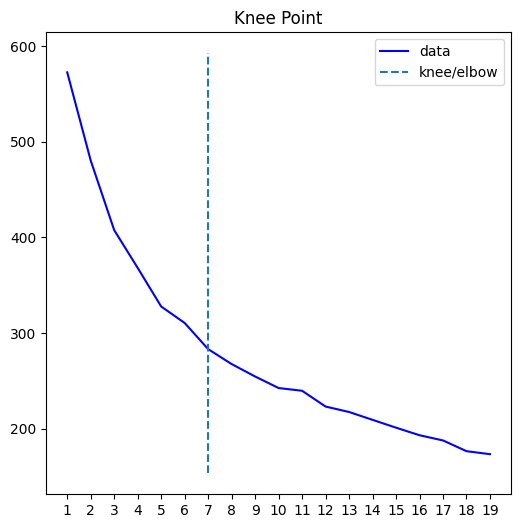

In [141]:
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_) # Сумма квадратов расстояний выборок до их ближайшего центра кластера

kneeLocator = KneeLocator(K, distortions, curve="convex", direction="decreasing")

kneeLocator.plot_knee()
plt.xticks(np.arange(min(K), max(K) + 1, 1.0))
plt.show()

In [142]:
kmeanModel = KMeans(n_clusters=kneeLocator.knee)
kmeanModel = kmeanModel.fit_predict(df)

Counter(kmeanModel)

Counter({3: 167, 5: 152, 4: 151, 0: 148, 6: 129, 2: 128, 1: 125})

#### DBSCAN

0.27235065867118413

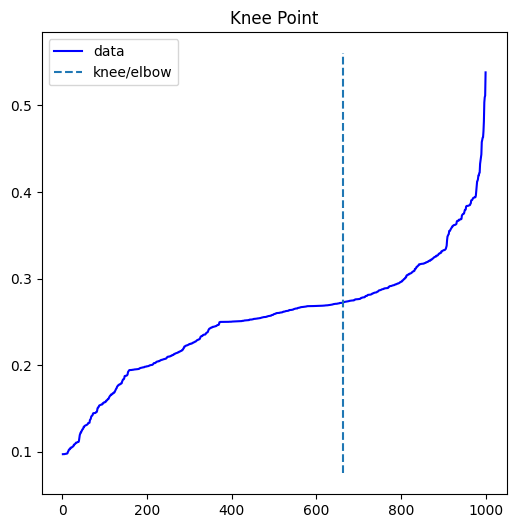

In [143]:
neighbors = NearestNeighbors().fit(df)
neighborsDist, neighborsInd = neighbors.kneighbors(df)
sortNeighborDist = np.sort(neighborsDist, axis=0)

x = range(1, len(neighborsDist) + 1)
y = sortNeighborDist[:, 3]

kneeLocator = KneeLocator(x, y, curve="convex", S=35)
knee = kneeLocator.knee_y
display(knee)
kneeLocator.plot_knee()
plt.show()

In [144]:
clusters = DBSCAN(eps=knee, min_samples=13).fit(df)
Counter(clusters.labels_)

Counter({-1: 962, 0: 25, 1: 13})

### Визуализация

#### PCA (Метод главных компонент)

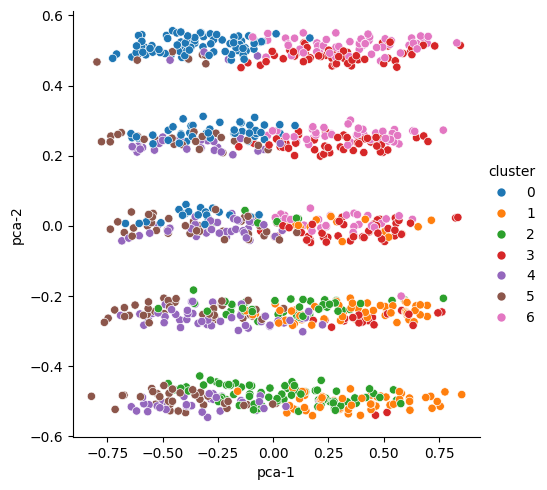

In [145]:
subsetLen = len(df)
subsetDf = df[:subsetLen]

PCAModel = PCA(n_components=2)
PCAData = PCAModel.fit_transform(subsetDf)

PCADf = pd.DataFrame()
PCADf['pca-1'] = PCAData[:, 0]
PCADf['pca-2'] = PCAData[:, 1]

PCADf['cluster'] = kmeanModel[: subsetLen]
PCADf['cluster'] = PCADf['cluster'].astype('category')

sns.relplot(x='pca-1', y='pca-2', hue="cluster", data=PCADf)
plt.show()

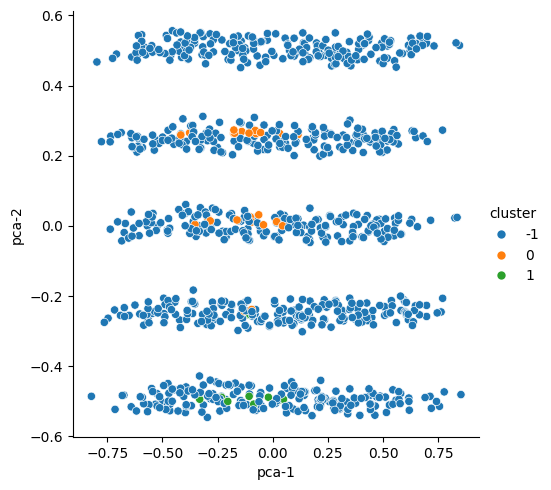

In [146]:
PCADf['cluster'] = clusters.labels_[:subsetLen]
PCADf['cluster'] = PCADf['cluster'].astype('category')

sns.relplot(x='pca-1', y='pca-2', hue="cluster", data=PCADf)
plt.show()

#### t-SNE (Стохастическое вложение соседей с t-распределением)

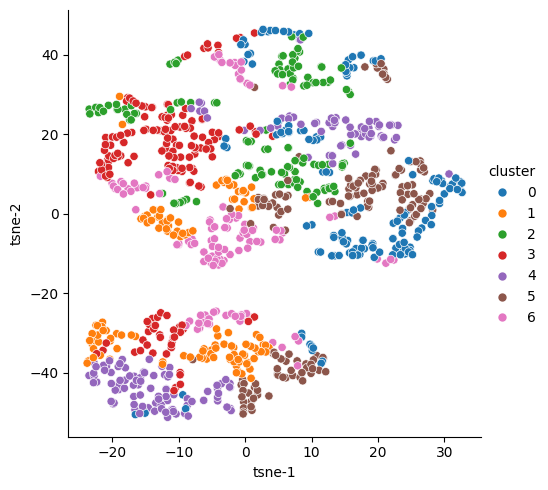

In [147]:
subsetLen = len(df)
subsetDf = df[:subsetLen]

tSNEModel = TSNE(n_components=2)
tSNEData = tSNEModel.fit_transform(subsetDf)

tSNEDf = pd.DataFrame()
tSNEDf['tsne-1'] = tSNEData[:, 0]
tSNEDf['tsne-2'] = tSNEData[:, 1]

tSNEDf['cluster'] = kmeanModel[: subsetLen]
tSNEDf['cluster'] = tSNEDf['cluster'].astype('category')

sns.relplot(x='tsne-1', y='tsne-2', hue="cluster", data=tSNEDf)
plt.show()

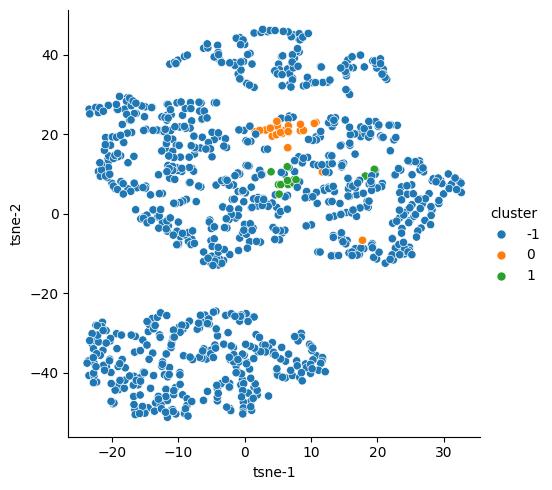

In [148]:
tSNEDf['cluster'] = clusters.labels_[:subsetLen]
tSNEDf['cluster'] = tSNEDf['cluster'].astype('category')

sns.relplot(x='tsne-1', y='tsne-2', hue="cluster", data=tSNEDf)
plt.show()

In [149]:
dfCopy['cluster_kmeans'] = kmeanModel
dfCopy['cluster_kmeans'] = dfCopy['cluster_kmeans'].astype('category')

In [150]:
dfCopyFilter = dfCopy[dfCopy.cluster_kmeans == 0]
dfCopyFilter.describe()

,Make,Model,Year,Mileage,Condition,Price
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.567568,1.858108,2012.175676,89117.851351,0.878378,25368.479730
std,0.720564,1.178089,1.677041,38495.484160,0.520405,2370.842326
min,0.000000,0.000000,2010.000000,11470.000000,0.000000,20164.400000
25%,0.000000,1.000000,2011.000000,56869.000000,1.000000,23548.137500
50%,0.000000,2.000000,2012.000000,97590.000000,1.000000,25028.675000
75%,1.000000,3.000000,2013.000000,120927.000000,1.000000,27225.650000
max,2.000000,4.000000,2017.000000,149794.000000,2.000000,31353.950000


In [151]:
dfCopyFilter = dfCopy[dfCopy.cluster_kmeans == 1]
dfCopyFilter.describe()

,Make,Model,Year,Mileage,Condition,Price
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000
mean,3.272000,1.312000,2019.312000,94891.104000,1.600000,17943.48960
std,0.699954,1.138873,2.204892,38140.417427,0.491869,2503.81662
min,2.000000,0.000000,2013.000000,11052.000000,1.000000,12875.90000
25%,3.000000,0.000000,2018.000000,65155.000000,1.000000,16048.20000
50%,3.000000,1.000000,2020.000000,103903.000000,2.000000,17784.25000
75%,4.000000,2.000000,2021.000000,125852.000000,2.000000,20138.20000
max,4.000000,4.000000,2022.000000,149648.000000,2.000000,22719.05000
